# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
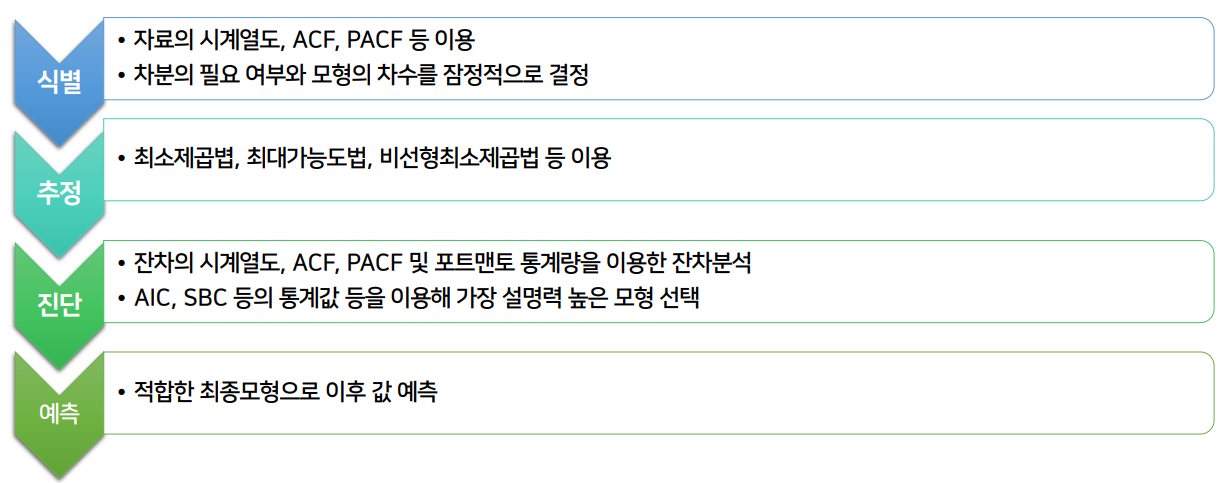

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [1]:
import os

import pandas as pd
#import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import yfinance as yf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

C:\Users\Jiwoo\AppData\Local\Temp\ipykernel_27684\827429045.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 데이터 불러오기

In [49]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [46]:
samsung_df.info()

# 결측치 없음

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2020-01-02 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   322 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


* 결측치 없음

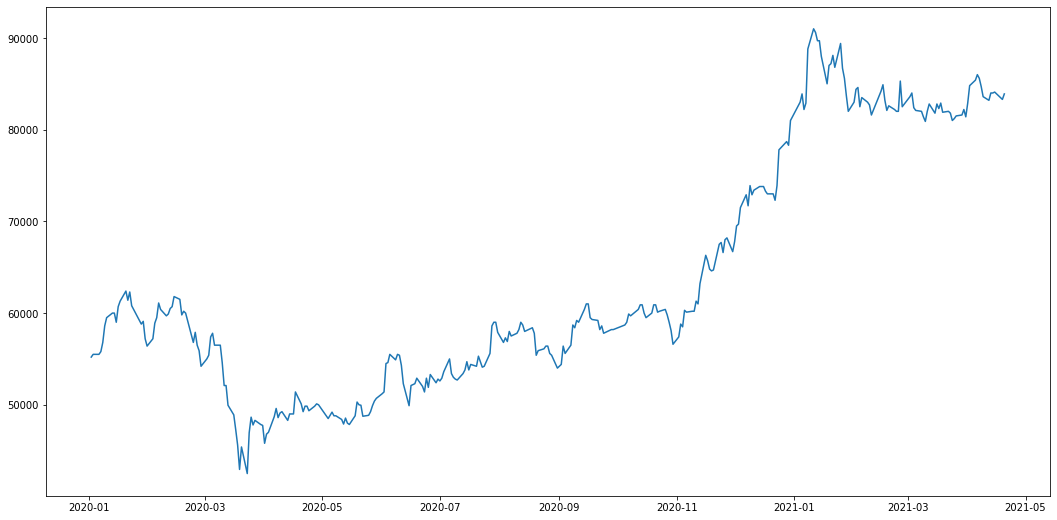

In [5]:
plt.figure(figsize=(18,9))
plt.plot(samsung_df.index, samsung_df["price"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Stock Price')
plt.show()

* 불규칙적이나 평균이 일정하지 않은 모습
* 하락하는 구간이 있으나 전반적으로 시간이 흐를수록 증가하는 추세
* 비정상 시계열로 판단

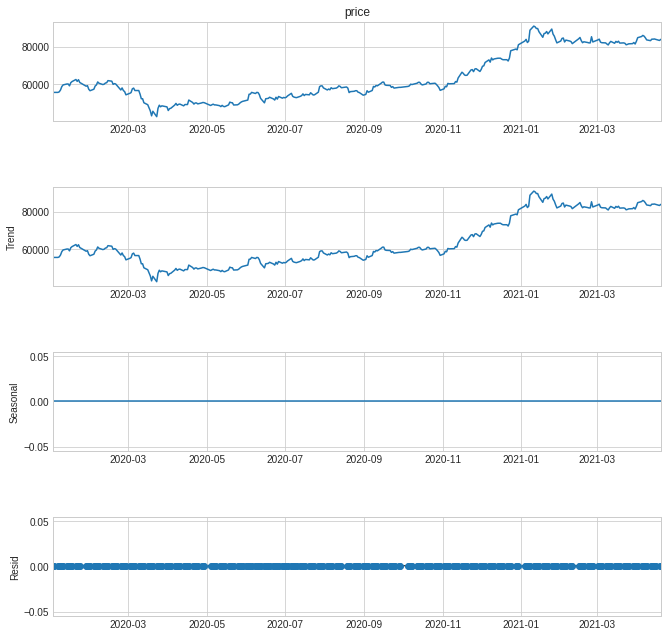

In [58]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(samsung_df['price'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

* 분해로 추세 없애지 못함

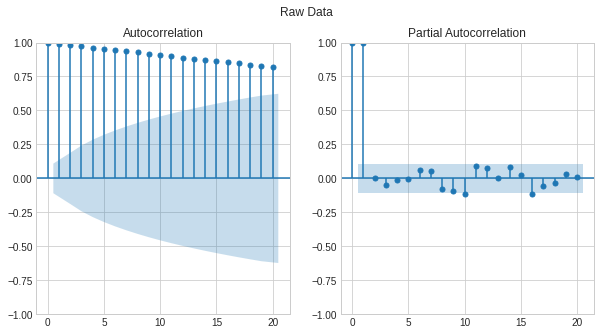

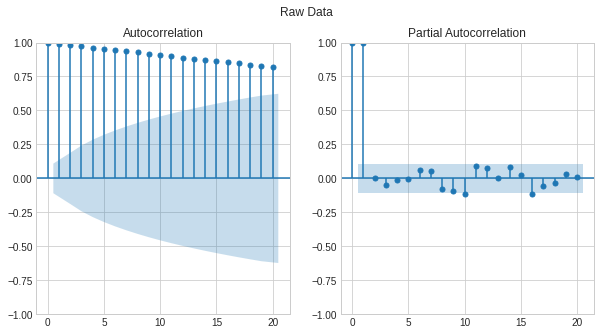

In [47]:
# 정상성(Stationarity) 검정 - ACF, PACF

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(samsung_df['price'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(samsung_df['price'].values.squeeze(), lags=20, ax=ax[1])

* ACF이 감소하는 추세 -> 비정상 시계열
* 차분(Differencing) 과정 필요

In [50]:
# 차분 (Differencing)

diff_series = samsung_df.copy()
diff_series = diff_series['price'].diff() # 차분
diff_series = diff_series.dropna() # 차분 후 생기는 결측치 제거
print(f"{'-'*15}Raw data{'-'*15}")
print(samsung_df['price'].head())
print(f"{'-'*15}Differenced data{'-'*15}")
print(diff_series.head())

---------------Raw data---------------
day
2020-01-02    55200.0
2020-01-03    55500.0
2020-01-06    55500.0
2020-01-07    55800.0
2020-01-08    56800.0
Name: price, dtype: float64
---------------Differenced data---------------
day
2020-01-03     300.0
2020-01-06       0.0
2020-01-07     300.0
2020-01-08    1000.0
2020-01-09    1800.0
Name: price, dtype: float64


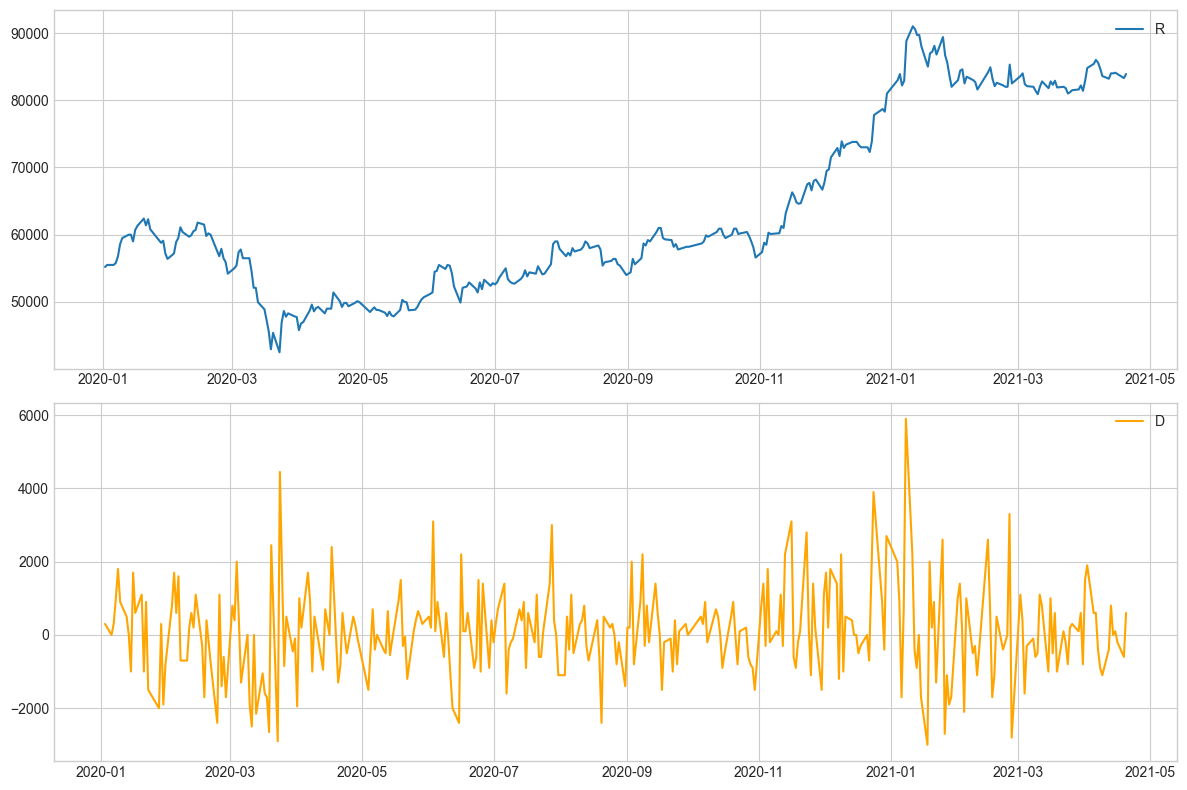

In [6]:
# 차분(Differencing) 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(samsung_df['price'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_series, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

* 노란색 그래프 : 제법 정상적인 시계열의 모습 확인

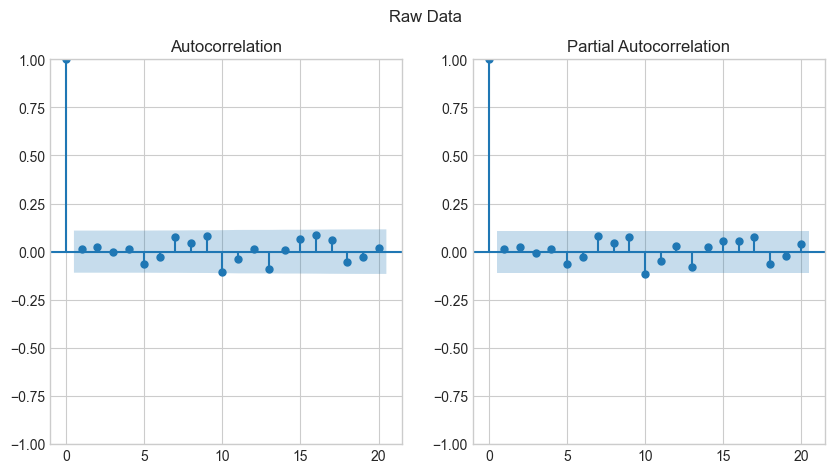

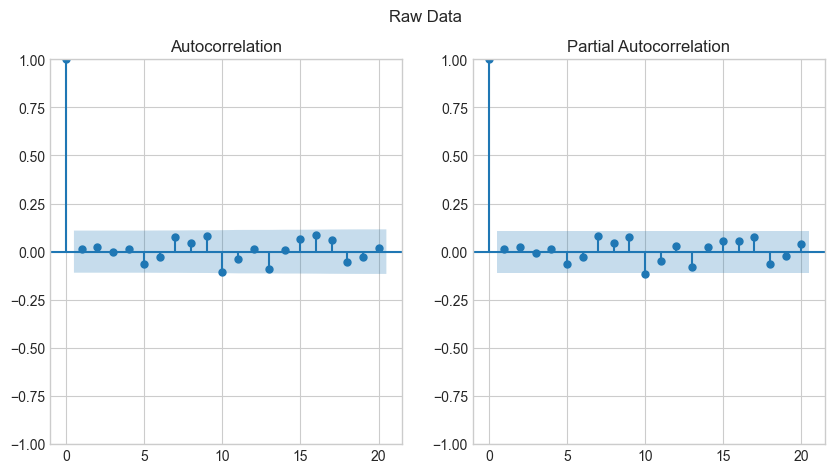

In [8]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_series.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_series.values.squeeze(), lags=20, ax=ax[1])

* ACF가 구간 안에 들어옴

In [51]:
size = int(len(diff_series.dropna()) * 0.75)
train, test = diff_series.dropna()[0:size], diff_series.dropna()[size:len(diff_series.dropna())]

In [52]:
train

day
2020-01-03     300.0
2020-01-06       0.0
2020-01-07     300.0
2020-01-08    1000.0
2020-01-09    1800.0
               ...  
2020-12-14     400.0
2020-12-15       0.0
2020-12-16       0.0
2020-12-17    -500.0
2020-12-18    -300.0
Name: price, Length: 240, dtype: float64

In [53]:
test

day
2020-12-21       0.0
2020-12-22    -700.0
2020-12-23    1600.0
2020-12-24    3900.0
2020-12-28     900.0
               ...  
2021-04-14       0.0
2021-04-15     100.0
2021-04-16    -200.0
2021-04-19    -600.0
2021-04-20     600.0
Name: price, Length: 81, dtype: float64

In [54]:
history = [x for x in train]
history

[300.0,
 0.0,
 300.0,
 1000.0,
 1800.0,
 900.0,
 500.0,
 0.0,
 -1000.0,
 1700.0,
 600.0,
 1100.0,
 -1000.0,
 900.0,
 -1500.0,
 -2000.0,
 300.0,
 -1900.0,
 -800.0,
 800.0,
 1700.0,
 600.0,
 1600.0,
 -700.0,
 -700.0,
 200.0,
 600.0,
 200.0,
 1100.0,
 -300.0,
 -1700.0,
 400.0,
 -200.0,
 -800.0,
 -2400.0,
 1100.0,
 -1400.0,
 -600.0,
 -1700.0,
 800.0,
 400.0,
 2000.0,
 400.0,
 -1300.0,
 0.0,
 -1900.0,
 -2500.0,
 0.0,
 -2150.0,
 -1050.0,
 -1600.0,
 -1700.0,
 -2650.0,
 2450.0,
 -2900.0,
 4450.0,
 1700.0,
 -850.0,
 500.0,
 -450.0,
 -100.0,
 -1950.0,
 1000.0,
 200.0,
 1700.0,
 900.0,
 -1000.0,
 500.0,
 150.0,
 -950.0,
 700.0,
 0.0,
 2400.0,
 -1300.0,
 -850.0,
 600.0,
 0.0,
 -500.0,
 500.0,
 250.0,
 -100.0,
 -1500.0,
 700.0,
 -400.0,
 0.0,
 -400.0,
 -500.0,
 650.0,
 -550.0,
 -150.0,
 950.0,
 1500.0,
 -300.0,
 -50.0,
 -1200.0,
 100.0,
 400.0,
 650.0,
 500.0,
 300.0,
 500.0,
 200.0,
 3100.0,
 100.0,
 900.0,
 -600.0,
 600.0,
 -100.0,
 -1100.0,
 -2000.0,
 -2400.0,
 2200.0,
 100.0,
 100.0,
 600.0,
 -

In [19]:
size = int(len(diff_series.dropna()) * 0.75)        # train : test = 0.75 : 0.25
train, test = diff_series.dropna()[0:size], diff_series.dropna()[size:len(diff_series.dropna())]
history = [x for x in train]
predictions = []

In [64]:
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))       # 최적 파라미터 바탕으로 ARIMA 모델 생성
    model_fit = model.fit()
    output = model_fit.forecast()       # 예측 진행
    yhat = output[0]        # 예측값을 yhat 변수에 저장한 뒤,
    predictions.append(yhat)        # 예측값을 모아놓는 리스트인 predictions에 for문 돌리면서 append 해주기
    obs = test[t]       # 해당 예측값에 대응하는 실제 test 데이터를 변수 obs에 저장한 뒤,
    history.append(obs)     # train 데이터 실제값이 들어있는 리스트 history에 append 해주기

In [65]:
# ARIMA 모델을 통한 test 예측값
predictions

[74.10142656038619,
 73.7905010346579,
 70.57460064357372,
 76.9015493272002,
 93.73542857502798,
 97.3344292965163,
 94.84962914739697,
 344.69451063593806,
 418.3922172662142,
 443.7311941328323,
 343.5986189487876,
 356.64684043409665,
 619.4041801547437,
 740.5713716653581,
 651.2694639110739,
 553.496945421942,
 524.7352440531611,
 425.1100576179824,
 311.50089263680866,
 357.9571156782954,
 353.16888476472957,
 369.0898334610763,
 321.25670463305073,
 382.53632860791004,
 297.0133980786263,
 116.44298380552596,
 107.82650543091313,
 100.7846470199222,
 104.09745256774704,
 108.94837781120145,
 109.28417960704517,
 100.79426831232104,
 104.196470403695,
 101.89856429961196,
 100.43551987515434,
 95.90452036317924,
 105.23039060902693,
 107.3967538115055,
 100.71960202988635,
 96.27670148230231,
 97.83065830058581,
 95.96043815965169,
 94.90767904147322,
 94.57127927639672,
 106.09540215391826,
 95.65493891099004,
 99.18063917269092,
 100.23300067730179,
 94.29829743730397,
 92.922

In [66]:
# train, test 모든 데이터의 실제값
history

[300.0,
 0.0,
 300.0,
 1000.0,
 1800.0,
 900.0,
 500.0,
 0.0,
 -1000.0,
 1700.0,
 600.0,
 1100.0,
 -1000.0,
 900.0,
 -1500.0,
 -2000.0,
 300.0,
 -1900.0,
 -800.0,
 800.0,
 1700.0,
 600.0,
 1600.0,
 -700.0,
 -700.0,
 200.0,
 600.0,
 200.0,
 1100.0,
 -300.0,
 -1700.0,
 400.0,
 -200.0,
 -800.0,
 -2400.0,
 1100.0,
 -1400.0,
 -600.0,
 -1700.0,
 800.0,
 400.0,
 2000.0,
 400.0,
 -1300.0,
 0.0,
 -1900.0,
 -2500.0,
 0.0,
 -2150.0,
 -1050.0,
 -1600.0,
 -1700.0,
 -2650.0,
 2450.0,
 -2900.0,
 4450.0,
 1700.0,
 -850.0,
 500.0,
 -450.0,
 -100.0,
 -1950.0,
 1000.0,
 200.0,
 1700.0,
 900.0,
 -1000.0,
 500.0,
 150.0,
 -950.0,
 700.0,
 0.0,
 2400.0,
 -1300.0,
 -850.0,
 600.0,
 0.0,
 -500.0,
 500.0,
 250.0,
 -100.0,
 -1500.0,
 700.0,
 -400.0,
 0.0,
 -400.0,
 -500.0,
 650.0,
 -550.0,
 -150.0,
 950.0,
 1500.0,
 -300.0,
 -50.0,
 -1200.0,
 100.0,
 400.0,
 650.0,
 500.0,
 300.0,
 500.0,
 200.0,
 3100.0,
 100.0,
 900.0,
 -600.0,
 600.0,
 -100.0,
 -1100.0,
 -2000.0,
 -2400.0,
 2200.0,
 100.0,
 100.0,
 600.0,
 -

In [75]:
date_index = test.reset_index()['day']

In [80]:
date_index

0    2020-12-21
1    2020-12-22
2    2020-12-23
3    2020-12-24
4    2020-12-28
        ...    
76   2021-04-14
77   2021-04-15
78   2021-04-16
79   2021-04-19
80   2021-04-20
Name: day, Length: 81, dtype: datetime64[ns]

In [90]:
pred_df = pd.DataFrame(predictions)
pred_df = pd.concat([date_index, pred_df], axis=1)
pred_df.rename(columns={0:'prediction'}, inplace=True)
pred_df

,day,prediction
0,2020-12-21,74.101427
1,2020-12-22,73.790501
2,2020-12-23,70.574601
3,2020-12-24,76.901549
4,2020-12-28,93.735429
...,...,...
76,2021-04-14,90.989163
77,2021-04-15,90.702169
78,2021-04-16,90.731527
79,2021-04-19,89.823017


In [76]:
predictions

[74.10142656038619,
 73.7905010346579,
 70.57460064357372,
 76.9015493272002,
 93.73542857502798,
 97.3344292965163,
 94.84962914739697,
 344.69451063593806,
 418.3922172662142,
 443.7311941328323,
 343.5986189487876,
 356.64684043409665,
 619.4041801547437,
 740.5713716653581,
 651.2694639110739,
 553.496945421942,
 524.7352440531611,
 425.1100576179824,
 311.50089263680866,
 357.9571156782954,
 353.16888476472957,
 369.0898334610763,
 321.25670463305073,
 382.53632860791004,
 297.0133980786263,
 116.44298380552596,
 107.82650543091313,
 100.7846470199222,
 104.09745256774704,
 108.94837781120145,
 109.28417960704517,
 100.79426831232104,
 104.196470403695,
 101.89856429961196,
 100.43551987515434,
 95.90452036317924,
 105.23039060902693,
 107.3967538115055,
 100.71960202988635,
 96.27670148230231,
 97.83065830058581,
 95.96043815965169,
 94.90767904147322,
 94.57127927639672,
 106.09540215391826,
 95.65493891099004,
 99.18063917269092,
 100.23300067730179,
 94.29829743730397,
 92.922

In [97]:
test_df = pd.DataFrame(test).reset_index()
test_df

,day,price
0,2020-12-21,0.0
1,2020-12-22,-700.0
2,2020-12-23,1600.0
3,2020-12-24,3900.0
4,2020-12-28,900.0
...,...,...
76,2021-04-14,0.0
77,2021-04-15,100.0
78,2021-04-16,-200.0
79,2021-04-19,-600.0


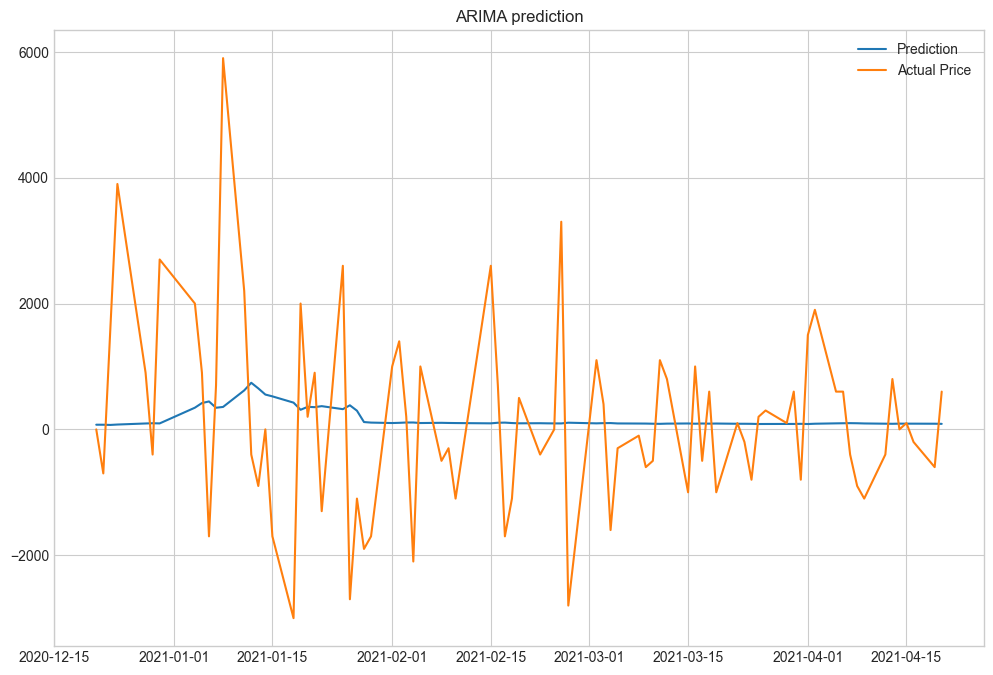

In [99]:
# test 실제값, 예측값 비교 시각화

plt.figure(figsize=(12,8))
plt.plot(pred_df['day'], pred_df['prediction'], label="Prediction")
plt.plot(test_df['day'], test_df['price'], label="Actual Price")
plt.title("ARIMA prediction")
plt.legend()
plt.show()

In [31]:
# 최적 파라미터 탐색

p = range(0, 2)
d = range(1, 3)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))

AIC = []
for i in pdq :
    model = ARIMA(train.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))

ARIMA pdq : (0, 1, 0) >> AIC : 4205.48
ARIMA pdq : (0, 1, 1) >> AIC : 4044.57
ARIMA pdq : (0, 2, 0) >> AIC : 4458.98
ARIMA pdq : (0, 2, 1) >> AIC : 4195.46
ARIMA pdq : (1, 1, 0) >> AIC : 4119.39
ARIMA pdq : (1, 1, 1) >> AIC : 4046.19
ARIMA pdq : (1, 2, 0) >> AIC : 4292.86
ARIMA pdq : (1, 2, 1) >> AIC : 4110.24


* AIC가 가장 적어지는 파라미터 선택 : (0, 1, 1)

In [55]:
# 최적 파라미터 선택
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

Found Optimal Parameter : [((0, 1, 1), 4044.57)]


<h2>ARIMA 모델 적용

In [67]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  320
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2723.397
Date:                Tue, 29 Aug 2023   AIC                           5450.794
Time:                        22:31:57   BIC                           5458.324
Sample:                             0   HQIC                          5453.801
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      0.225     -4.440      0.000      -1.441      -0.559
sigma2       1.51e+06   3.18e+05      4.752      0.000    8.87e+05    2.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                62.72
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             0.56
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h1> Prophet Forecast

In [101]:
samsung_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2020-01-02 to 2021-04-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   322 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


In [103]:
df_pr = samsung_df.copy()
df_pr = df_pr.reset_index()
df_pr.columns = ['ds', 'p']
df_pr

,ds,p
0,2020-01-02,55200.0
1,2020-01-03,55500.0
2,2020-01-06,55500.0
3,2020-01-07,55800.0
4,2020-01-08,56800.0
...,...,...
317,2021-04-14,84000.0
318,2021-04-15,84100.0
319,2021-04-16,83900.0
320,2021-04-19,83300.0


In [111]:
train_data_pr = df_pr.iloc[:len(df_pr)-81]
test_data_pr = df_pr.iloc[len(df_pr)-81:]

In [112]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
m = Prophet()
m.fit(train_data_pr)

In [ ]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=81,freq='MS')
prophet_pred = m.predict(future)